In [43]:
import requests
import json
import mysql.connector
#from getpass import getpass
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.ops import cascaded_union
import fiona
import matplotlib.pyplot as plt
plt.style.use('bmh')
from initialization import Initialization

In [44]:
# Get insert example: response = requests.get("http://spacemakerai.com/insert")
#url = "http://json.extendsclass.com/bin/b6a9f90d20dd" #insert

#Get update example: response = requests.get("http://spacemakerai.com/edit")
url = "http://json.extendsclass.com/bin/bc18e7bb426e" # Update

In [45]:
inst = Initialization(url)
inst.values()

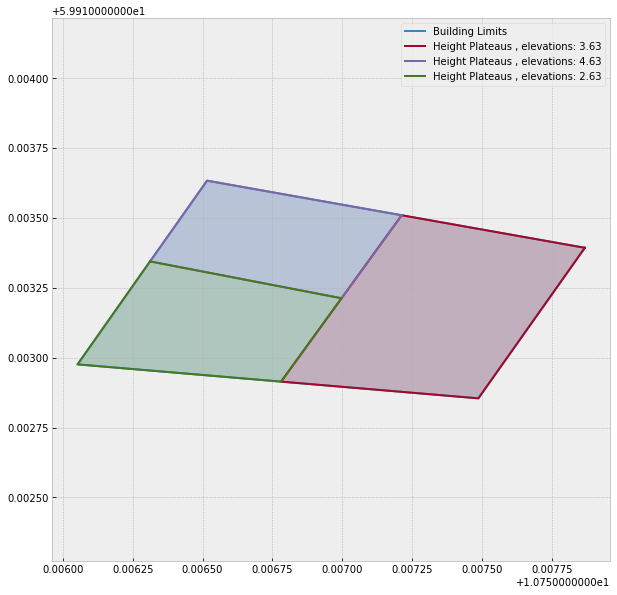

In [46]:
polygons = MultiPolygon(inst.polys)

fig, ax = plt.subplots(figsize=(10,10))
k = 0
# Plot Polygon
for poly in polygons.geoms:
    xe, ye = poly.exterior.xy
    ax.plot(xe, ye,  label=inst.labels[k])
    ax.axis('equal')
    #ax.patch.set(facecolor ='green', alpha=0.1)
    plt.fill(xe, ye, alpha=0.2)
    ax.get_legend_handles_labels()
    leg = ax.legend();
    k += 1
#plt.show()

In [47]:
###### Error handeling #########

In [59]:
hpoly_union = gpd.GeoSeries(inst.hpolys)

if sum(hpoly_union.area)-inst.hareas != 0:
    print('Error 1: Height Plateaus Polygons have overalp')
     #response = requests.post('http://spacemakerai.com/post/errors', json={
     #  "message": "Error 111: Height Plateaus Polygons have overalp",
     #})
    
elif inst.hareas < inst.polys[0].area:
    print('Error 2: There is a gap between Height Plateaus Polygons')  
     #response = requests.post('http://spacemakerai.com/post/input', json={
     #  "message": "Error 112: There is a gap between Height Plateaus Polygons",
     #})

elif inst.reqs == 'insert':
    # Connect to the google cloud mySQL database
    spdb = mysql.connector.connect(
      host="35.228.50.144",
      user="root",
      password="123",
      database="bhs"
    )
    # Check if th building ID exists or not
    spcursor = spdb.cursor()
    query = f"select count(*) from building_height_split where input_id = {inst.inputId}"
    spcursor.execute(query)
    result = spcursor.fetchone()
    found = result[0]
    if found != 0:
        print('The building ID exists')
    else:
        # Insert Data
        sp_insert_query = """INSERT INTO building_height_split 
                            (Building_limits, Height_plateaus, Split_building_limits, input_id) 
                            VALUES (%s, %s, %s, %s)"""
        
        val = (str(inst.polys[0]), str(inst.height_plateaus_elevations), str(inst.hpolys), inst.inputId)

        spcursor.execute(sp_insert_query, val)
        spdb.commit()

        print(spcursor.rowcount, "Record inserted sucessfully.") # Should use post to send the message
        #response = requests.post('http://spacemakerai.com/post/insert', json={
        #  "message": "Sucess 201: Record inserted sucessfully",
        #})
        
elif inst.reqs == 'update':
    # Update with SELECT
    try:
        spdb = mysql.connector.connect(host="35.228.50.144",
                                              user="root",
                                              password="123",
                                              database="bhs")
        spdb.autocommit = False
        spcursor = spdb.cursor()
        update_IDexist = f"select count(*) from building_height_split where input_id = {inst.inputId}"
        spcursor.execute(update_IDexist)
        result = spcursor.fetchone()
        found = result[0]
        if found == 0:
            print('The input ID does not exist')
        else:
            sql_select_query = f"SELECT * FROM building_height_split WHERE input_id = {inst.inputId}"
            spcursor.execute(sql_select_query)
            record = spcursor.fetchone()
            #print(record)

            # Update single record now
            sql_update_query = """UPDATE building_height_split SET 
                                  Building_limits = %s,
                                  Height_plateaus= %s,
                                  Split_building_limits = %s 
                                  WHERE input_id = %s"""
            val = (str(inst.polys[0]), str(inst.height_plateaus_elevations), str(inst.hpolys), inst.inputId)
            spcursor.execute(sql_update_query, val)
            spdb.commit()
            print("Record Updated successfully")
            #response = requests.post('http://spacemakerai.com/post/update', json={
            # "message": "Success 301: Record Updated successfully",
            #})

            #print("Print the updated record:")
            spcursor.execute(sql_select_query)
            record = spcursor.fetchone()
            #print(record)

    except mysql.connector.Error as error:
        print("Failed to update table record: {}".format(error))
        spdb.rollback()
    finally:
        if spdb.is_connected():
            spcursor.close()
            spdb.close()
            print("MySQL connection is closed")
            #response = requests.post('http://spacemakerai.com/post/update', json={
            # "message": "Error 311: Failed to update the record",
            #})

Error 2: There is a gap between Height Plateaus Polygons
